In [35]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import tree
from sklearn.datasets import fetch_openml
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeRegressor

import warnings
warnings.filterwarnings("ignore")

**Task description** Fit (i.e., regression) the real variable Sales in the **Carseats** dataset, using decision tree, bagging, and random forests. All these algorithms can be implemented by calling **sklearn** in Python. The loss is set as sum of squared error (SSE).

[Analyze] Identify information contained on each axis.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    object 
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    object 
 10  US           400 non-null    object 
dtypes: float64(1), int64(7), object(3)
memory usage: 34.5+ KB
None
[Analyze] Identify range covered by each axis; Look for averages and/or exceptions.
            Sales   CompPrice      Income  Advertising  Population  \
count  400.000000  400.000000  400.000000   400.000000  400.000000   
me

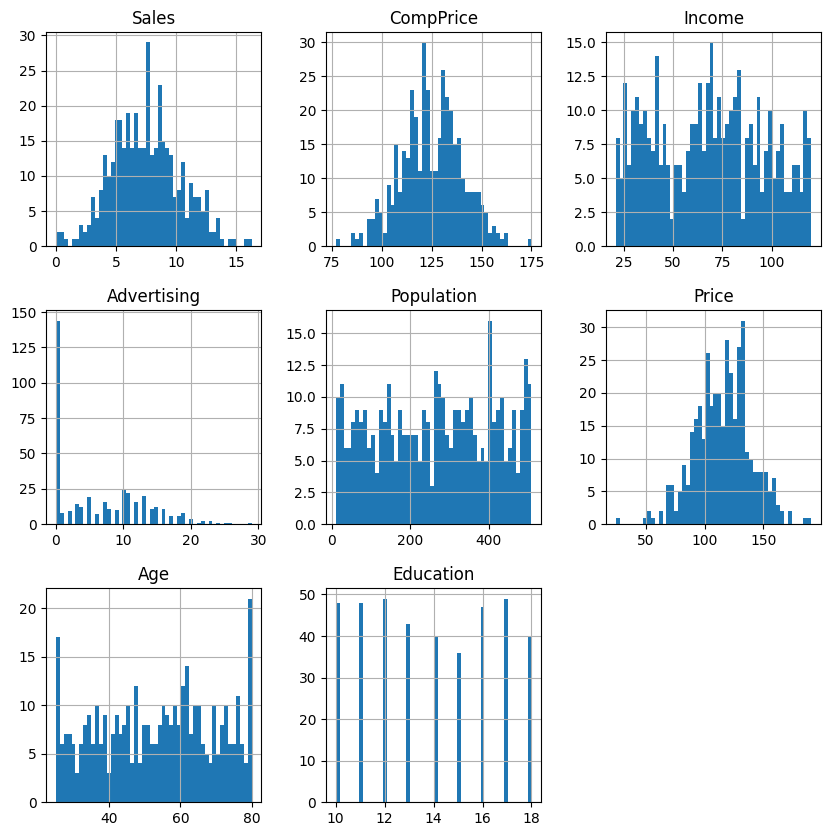

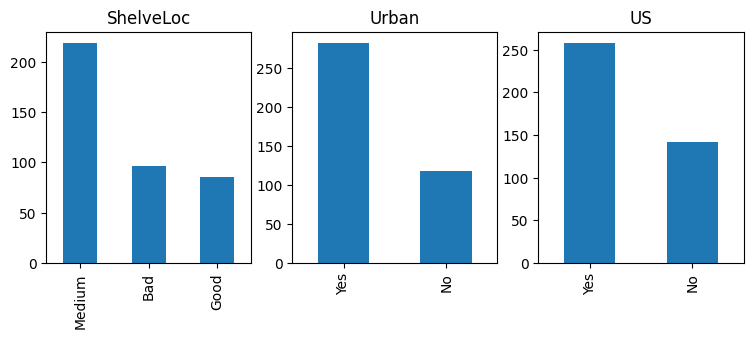

In [36]:
data = pd.read_csv("Carseats.csv")

# Data statistics

print("[Analyze] Identify information contained on each axis.")
print(data.info())

print("[Analyze] Identify range covered by each axis; Look for averages and/or exceptions.")
print(data.describe())

print("[Visualize] Read the data and visualize.")
data.hist(figsize = [10, 10], bins = 50)
plt.show()

figure = 1 #random number
for attribute in ["ShelveLoc", "Urban", "US"]:
    plt.subplot(1, 3, figure)
    data[attribute].value_counts().plot(kind = "bar", title = attribute, figsize = [9, 3])
    figure += 1

plt.show()

In [37]:
def quality_to_value(param):
    if param == "Bad":
        return -1
    elif param == "Medium":
        return 0
    elif param == "Good":
        return 1
    else:
        return (1 << 32) - 1

def statement_to_value(param):
    if param == "No":
        return 0
    elif param == "Yes":
        return 1
    else:
        return (1 << 32) - 1

copy_data = data.copy()

copy_data["ShelveLoc"] = copy_data["ShelveLoc"].apply(quality_to_value)
copy_data["Urban"] = copy_data["Urban"].apply(statement_to_value)
copy_data["US"] = copy_data["US"].apply(statement_to_value)

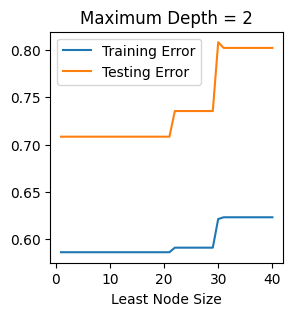

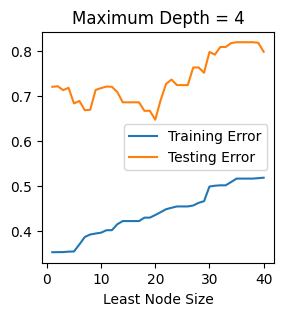

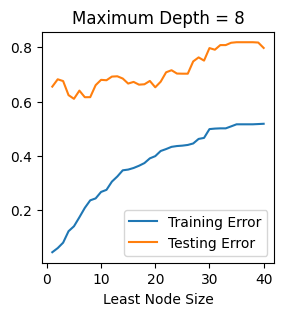

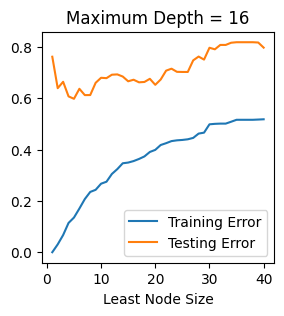

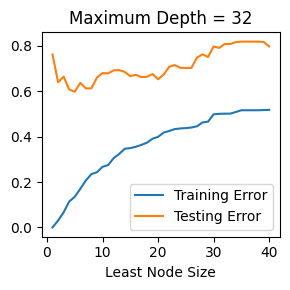

I randomly choose max_depth = 8 and min_samples_leaf = 20 as a representation of the learned tree.


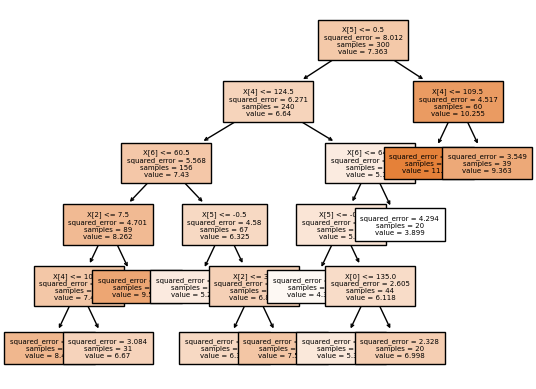

In [39]:
# Decision tree

X_train, y_train = copy_data.drop(["Sales"], axis = 1)[:300], data[:300]["Sales"]
X_test, y_test   = copy_data.drop(["Sales"], axis = 1)[300:], data[300:]["Sales"]

figure = 1
max_depths = [(2 ** k) for k in range(1, 6)]
min_samples_leaves = [k for k in range(1, 41)]

for max_depth in max_depths:
    training_errors = []
    testing_errors = []
    
    for min_samples_leaf in min_samples_leaves:
        clf = DecisionTreeRegressor(random_state = 120040025, 
                                    max_depth = max_depth, 
                                    min_samples_leaf = min_samples_leaf)
        clf.fit(X_train, y_train)
        training_errors.append(1 - clf.score(X_train, y_train))
        testing_errors.append(1 - clf.score(X_test, y_test))
        
    plt.figure(figure, figsize = [3, 3])
    figure += 1
    plt.plot(min_samples_leaves, 
             training_errors, 
             label = "Training Error")
    plt.plot(min_samples_leaves, 
             testing_errors, 
             label = "Testing Error")
    plt.title("Maximum Depth = " + str(max_depth))
    plt.xlabel("Least Node Size")
    plt.legend()

plt.tight_layout()
plt.show()

print("I randomly choose max_depth = 8 and min_samples_leaf = 20 as a representation of the learned tree.")
clf = DecisionTreeRegressor(random_state = 120040025, 
                            max_depth = 8, 
                            min_samples_leaf = 20)
clf.fit(X_train, y_train)
returned_value = tree.plot_tree(clf, 
                                filled = True, 
                                fontsize = 5, 
                                impurity = True)

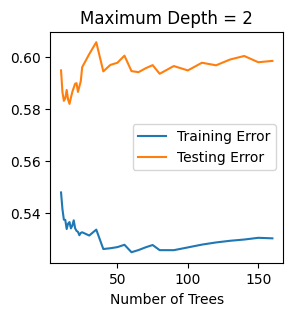

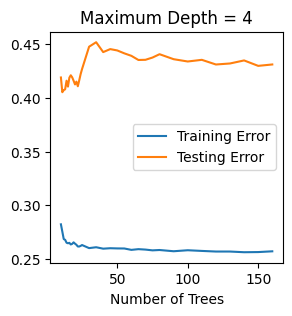

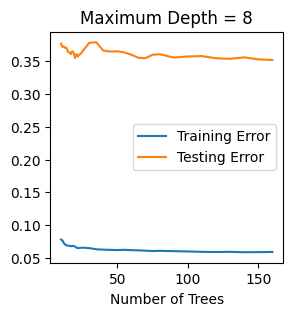

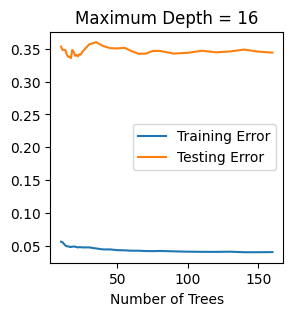

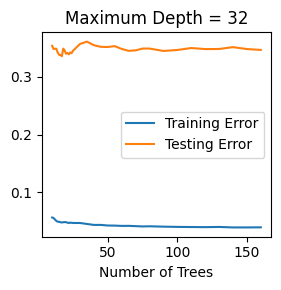

In [40]:
# Bagging of trees

X_train, y_train = copy_data.drop(["Sales"], axis = 1)[:300], data[:300]["Sales"]
X_test, y_test   = copy_data.drop(["Sales"], axis = 1)[300:], data[300:]["Sales"]

figure = 1
max_depths = [(2 ** k) for k in range(1, 6)]
n_estimators_list = [k for k in range(10, 25)] + [5 * k for k in range(5, 17)] + [10 * k for k in range(8, 17)]

for max_depth in max_depths:
    training_errors = []
    testing_errors = []
    
    for n_estimators in n_estimators_list:
        dt = DecisionTreeRegressor(random_state = 120040025,
                                   max_depth = max_depth)
        clf = BaggingRegressor(random_state = 120040025,
                               base_estimator = dt, 
                               n_estimators = n_estimators)
        clf.fit(X_train, y_train)
        training_errors.append(1 - clf.score(X_train, y_train))
        testing_errors.append(1 - clf.score(X_test, y_test))
        
    plt.figure(figure, figsize = [3, 3])
    figure += 1
    plt.plot(n_estimators_list, 
             training_errors, 
             label = "Training Error")
    plt.plot(n_estimators_list, 
             testing_errors, 
             label = "Testing Error")
    plt.title("Maximum Depth = " + str(max_depth))
    plt.xlabel("Number of Trees")
    plt.legend()

plt.tight_layout()
plt.show()

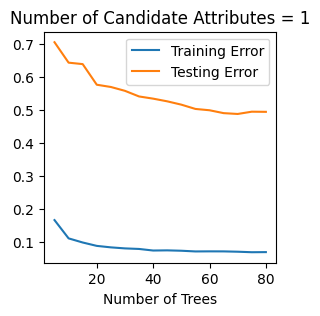

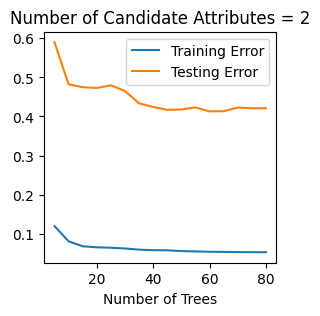

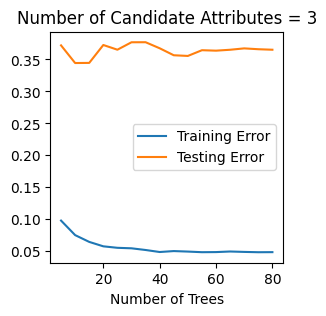

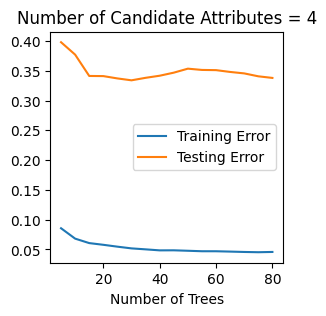

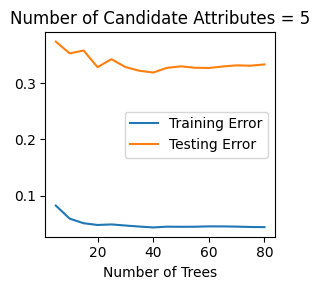

In [41]:
# Random forests

X_train, y_train = copy_data.drop(["Sales"], axis = 1)[:300], data[:300]["Sales"]
X_test, y_test   = copy_data.drop(["Sales"], axis = 1)[300:], data[300:]["Sales"]

figure = 1
max_features_list = [k for k in range(1, 6)]
n_estimators_list = [5 * k for k in range(1, 17)]

for max_features in max_features_list:
    training_errors = []
    testing_errors = []
    
    for n_estimators in n_estimators_list:
        clf = RandomForestRegressor(random_state = 120040025,
                                    n_estimators = n_estimators,
                                    max_features = max_features)
        clf.fit(X_train, y_train)
        training_errors.append(1 - clf.score(X_train, y_train))
        testing_errors.append(1 - clf.score(X_test, y_test))
        
    plt.figure(figure, figsize = [3, 3])
    figure += 1
    plt.plot(n_estimators_list, 
             training_errors, 
             label = "Training Error")
    plt.plot(n_estimators_list, 
             testing_errors, 
             label = "Testing Error")
    plt.title("Number of Candidate Attributes = " + str(max_features))
    plt.xlabel("Number of Trees")
    plt.legend()

plt.tight_layout()
plt.show()

I randomly choose max_features = 5 as a representation of the curve.


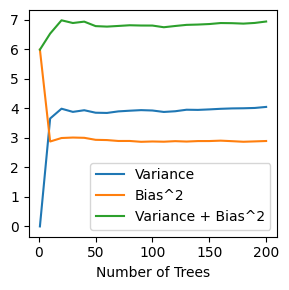

In [52]:
# Plot bias^2 curve

X_train, y_train = copy_data.drop(["Sales"], axis = 1)[:300], data[:300]["Sales"]
X_test, y_test   = copy_data.drop(["Sales"], axis = 1)[300:], data[300:]["Sales"]

print("I randomly choose max_features = 5 as a representation of the curve.")
max_features = 5
n_estimators_list = [1] + [10 * k for k in range(1, 21)]

variances = []
squared_biases = []
addition_results = []

for n_estimators in n_estimators_list:
    clf = DecisionTreeRegressor(random_state = 120040025)
    clf.fit(X_train, y_train)
    t_x = clf.predict(X_test) # t(x)
    
    clf = RandomForestRegressor(random_state = 120040025,
                                n_estimators = n_estimators,
                                max_features = max_features)
    clf.fit(X_train, y_train)
    h_x = [cl.predict(X_test) for cl in clf.estimators_] # h(x)
    h_mean = clf.predict(X_test) # h_

    N = len(y_test) # should be 100

    # Var = sum((h(x) - h_)^2) / N
    variances.append(np.average(np.array([(h_x[cl][i] - h_mean[i]) ** 2 for cl in range(n_estimators) for i in range(N)])))
    # bias^2(x) = (h_ - t(x))^2
    squared_biases.append(sum([(h_mean[i] - t_x[i]) ** 2 for i in range(N)]) / N)
    
    addition_results.append(variances[-1] + squared_biases[-1])
    
plt.figure(figure, figsize = [3, 3])
plt.plot(n_estimators_list, 
         variances, 
         label = "Variance")
plt.plot(n_estimators_list, 
         squared_biases, 
         label = "Bias^2")
plt.plot(n_estimators_list, 
         addition_results, 
         label = "Variance + Bias^2")
plt.xlabel("Number of Trees")
plt.legend()

plt.tight_layout()
plt.show()

**Task description** Use the function ”MLPClassifier” of sk-learn to construct a fully connected network to classify the MNIST data. The dataset can be downloaded from http://yann.lecun.com/exdb/mnist/. The training-testing spilliting has been given. Show the performance of your neural network with different structures:
- number of hidden layers chosen from {1, 2, 3}
- number of hidden nodes chosen from {50, 200, 784} (let all hidden layers have the same number of nodes)

In [5]:
mnist = fetch_openml("mnist_784", data_home = "MNIST-dataset-YannLeCun/") #this takes time, kindly wait :D
print(mnist)

{'data':        pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
0         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
69995     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69996     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69997     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69998     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
69999     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

       pixel10  ..

In [33]:
# don't re-run this unless you want to wait for a quite long time :<
# you can refer to the printed result (re-running the code will get the same result as the seed is fixed)

n = 70000

X_train, X_test, y_train, y_test = train_test_split(
    mnist.data.values[:n] / 255,
    np.array(mnist.target.values[:n], dtype = np.int),
    random_state = 120040025,
    test_size = 0.2 # split data: 80% as training set, 20% as training test
)

classes = np.sort(pd.unique(np.array(mnist.target.values[:n], dtype=np.int))) # should be [0 1 .. 9]

number_of_hidden_layers_list = [1, 2, 3]
number_of_hidden_nodes_list = [50, 200, 784]

for number_of_hidden_layers in number_of_hidden_layers_list:
    for number_of_hidden_nodes in number_of_hidden_nodes_list:
        clf = MLPClassifier(random_state = 120040025,
                            hidden_layer_sizes = [number_of_hidden_nodes] * number_of_hidden_layers,
                            max_iter = 61)
        clf.fit(X_train, y_train)

        print("When the number of hidden layers is", number_of_hidden_layers, "and the number of hidden nodes is", number_of_hidden_nodes)
        print("Training Error: {%.6f}" % (1 - clf.score(X_train, y_train)))
        print("Testing Error: {%.6f}" % (1 - clf.score(X_test, y_test)))

When the number of hidden layers is 1 and the number of hidden nodes is 50
Training Error: {0.000018}
Testing Error: {0.027571}
When the number of hidden layers is 1 and the number of hidden nodes is 200
Training Error: {0.000125}
Testing Error: {0.020571}
When the number of hidden layers is 1 and the number of hidden nodes is 784
Training Error: {0.000000}
Testing Error: {0.016714}
When the number of hidden layers is 2 and the number of hidden nodes is 50
Training Error: {0.000000}
Testing Error: {0.025786}
When the number of hidden layers is 2 and the number of hidden nodes is 200
Training Error: {0.000000}
Testing Error: {0.018357}
When the number of hidden layers is 2 and the number of hidden nodes is 784
Training Error: {0.000429}
Testing Error: {0.018000}
When the number of hidden layers is 3 and the number of hidden nodes is 50
Training Error: {0.000000}
Testing Error: {0.026071}
When the number of hidden layers is 3 and the number of hidden nodes is 200
Training Error: {0.00044